In [15]:
import lasio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sys import stdout
from openpyxl import Workbook


w1 = r'.\DATOS_EDITADOS\SNRG-0001_FINAL.las'
w2 = r'./Well_Logging/SNRG-0002_basic_logs.las'
w3 = r'./Well_Logging/SNRG-0003_basic_logs.las'
w4 = r'./Well_Logging/SNRG-0004_basic_logs.las'


In [16]:
las_1 = lasio.read(w1)
# las_1.to_csv(stdout)
df = las_1.df()
df.reset_index(inplace =True)
# df.to_excel("Registro_4.xlsx",sheet_name="Registro_4_Limpio",index=False)

In [18]:
#Cambio de nombres para diferentes tipos de cabezales
if "GRGC" in df:
    df = df.rename(columns={'GRGC':'GR'})
if ("RHOB" or "RHOZ") in df:
    df = df.rename(columns={'RHOB':'DEN'})
    df = df.rename(columns={'RHOZ':'DEN'})
if ("NPHI") in df:
    df = df.rename(columns={'NPHI':'NEU'})
if ("DDLL" or "AT90" or "RT" or "ILD") in df:
    df = df.rename(columns={'DDLL':'AT90'})
    df = df.rename(columns={'AT90':'AT90'})
    df = df.rename(columns={'RT':'AT90'})
    df = df.rename(columns={'IDL':'AT90'})
if ("PDPE" or "PEFZ") in df:
    df = df.rename(columns={'PDPE':'PEF'})
    df = df.rename(columns={'PEFZ':'PEF'})
df


,DEPTH,AT90,BIT,DCOR,DEN,DSLL,DT35,GR,NEU,NPRD,NPRL,NPRS,PEF,TOC
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17996,8998.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17997,8998.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17998,8999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17999,8999.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


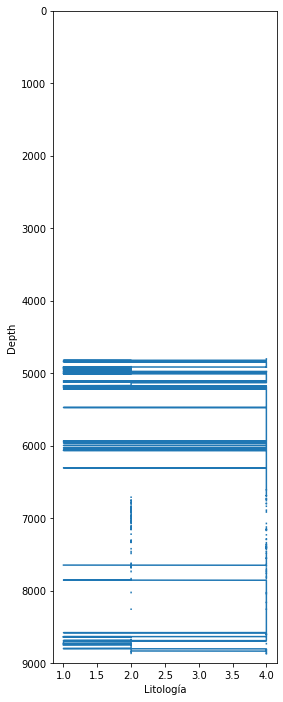

In [19]:
# Identifciación de los valores maximos y minimos del gamma ray
GR_max = df['GR'].max()
GR_min = df['GR'].min()

#Identificación de shale del resto de litologías
df.loc[df.GR>80,'Shale']= 1
df.loc[df.GR>80,'Litologia']= 1
df.loc[df.GR<80,'Shale']= 0

#Identificación de litologias mediante Neutron y Gamma Ray
df["Lit_ND"] = (df["DEN"] - 1.95) - (1 - (5/3)*(df["NEU"]+0.15))

# #Creación de la gráfica de litología
# fig , axs = plt.subplots(figsize=(4,12))
# plt.plot(df['Lit_ND'],df['DEPTH'])
# plt.xlabel('Litología')
# plt.ylabel('Depth')
# plt.ylim(max(df['DEPTH']),min(df['DEPTH']))
# # fig.savefig("DEPTH_vs_Lit_ND.png")

#Creacion de la litología con curvas
#Si es mayor a 0.03 Dolomita 4
df.loc[df.Lit_ND>0.03,'Litologia']= 4
#Si es menor -0.03 Arenisca  2
df.loc[df.Lit_ND < -0.03,'Litologia']= 2
#Si esta en el rango de -0.03 a 0.03 limolita 3
# df.loc[(df.Lit_ND >= -0.03 and df.Lit_ND <= -0.03) ,'Litologia']= 3
df
# #Creación de la gráfica de litología
fig , axs = plt.subplots(figsize=(4,12))
plt.plot(df['Litologia'],df['DEPTH'])
plt.xlabel('Litología')
plt.ylabel('Depth')
plt.ylim(max(df['DEPTH']),min(df['DEPTH']))
# fig.savefig("DEPTH_vs_Lit_ND.png")

df.to_excel('registro_prueba.xlsx',sheet_name='prueba',index=False)

In [6]:
# Gamma_Ray.plot()
# df.plot.scatter(x='GR',y='DEPTH:1',)

In [7]:
# df.plot.scatter(x='GR',y='DEPTH:1',)

In [8]:
GR = df['GR']
IGR = (GR-GR_min)/(GR_max-GR_min)
Vsh = 1.7 - (3.38-(IGR+0.7)**2)**0.5
Vsh.head()
Vsh.shape



(18001,)

In [9]:
df.plot.line(x='NPHI',y='DEPTH:1')

KeyError: 'NPHI'

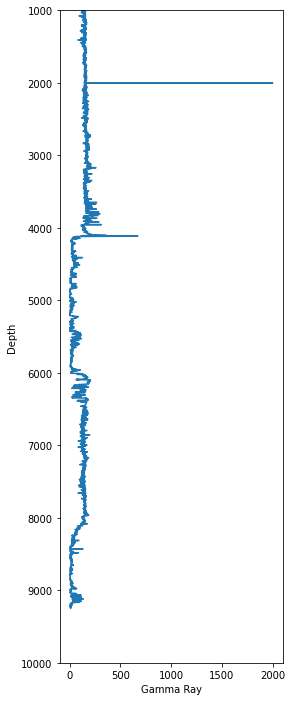

In [ ]:
fig , axs = plt.subplots(figsize=(4,12))
plt.plot(df['GR'],df['DEPTH:1'])
plt.xlabel('Gamma Ray')
plt.ylabel('Depth')
plt.ylim(max(df['DEPTH:1']),min(df['DEPTH:1']))
fig.savefig("Gammaray.png")


C:\Users\camil\Documents\Sinergia 2021\venv\lib\site-packages\pandas\plotting\_matplotlib\__init__.py:61: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


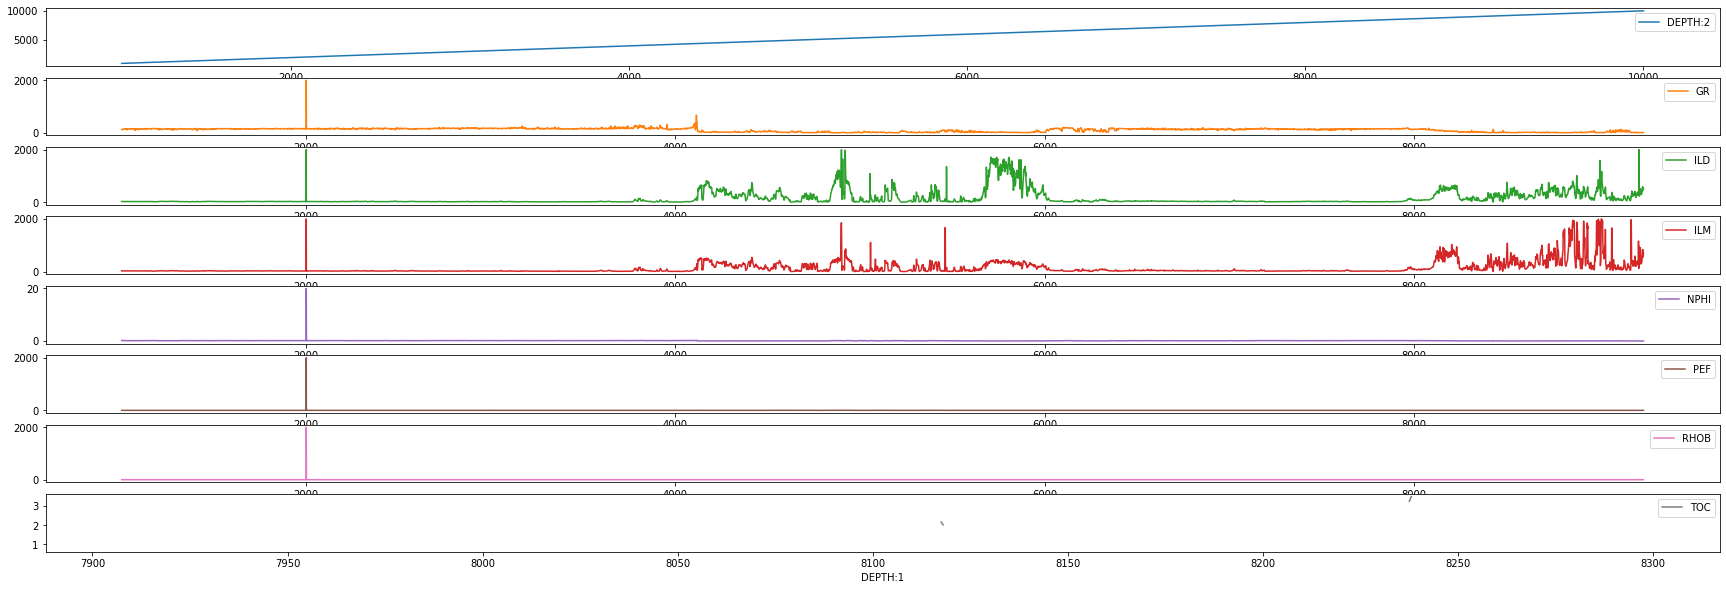

In [ ]:
fig, axs = plt.subplots(figsize=(30,10))
df.plot(x='DEPTH:1',ax = axs,figsize=(30,10),subplots=True)
fig.savefig("Resumen de registros.png")

(9000.0, 0.0)

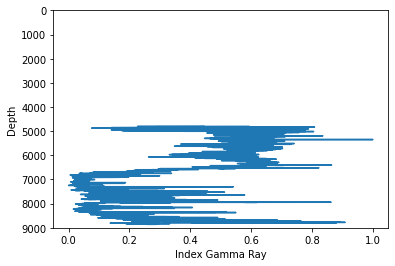

In [ ]:
df['IGR'] = (df['GR']-GR_min)/(GR_max-GR_min)
df['Vshale'] = 1.7 - (3.38-(df['IGR']+0.7**2))**0.5
plt.plot(df['IGR'],df['DEPTH:1'])
plt.xlabel('Index Gamma Ray')
plt.ylabel('Depth')
plt.ylim(max(df['DEPTH:1']),min(df['DEPTH:1']))

(9000.0, 0.0)

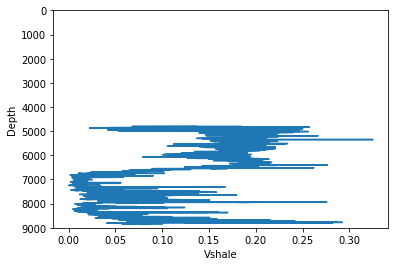

In [ ]:
plt.plot(df['Vshale'],df['DEPTH:1'])
plt.xlabel('Vshale')
plt.ylabel('Depth')
plt.ylim(max(df['DEPTH:1']),min(df['DEPTH:1']))

In [ ]:
# df.to_excel("Registro_1.xlsx",sheet_name="Registro_1",index=False)
df

,DEPTH,DDLL,BIT,DCOR,DEN,DSLL,DT35,GRGC,NPHI,NPRD,NPRL,NPRS,PDPE,TOC
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17996,8998.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17997,8998.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17998,8999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17999,8999.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
